In [1]:
import time

import matplotlib.cm as cmap
import matplotlib.pyplot as plt
import numpy as np
from teri_module_2D import Boundary_Def
from teri_module_2D import build_2D_matrix
from teri_module_2D import mat2vec
from teri_module_2D import Problem_Def
from teri_module_2D import vec2mat
from teri_module_2D import index_to_row_col
from mpl_toolkits.axes_grid1 import AxesGrid
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import spsolve
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display
from IPython.display import HTML
from numpy.testing import assert_allclose
import math

It looks like I am being run as a main program
My name is teri_module_2D




In [2]:
H = 14  #Head Pressure on one side of dam

In [3]:
#Need to define H as it changes through the tailings dam
#Need to define phreatic line
#reference https://nptel.ac.in/courses/105104132/Module2/lecture10.pdf
#j is iterations
#A is length of tailings dam
#H is total head pressure


def find_phreatic(H,A,r):
    x_p=np.zeros(r)
    y_p=np.zeros(r)
    p=0.5*(math.sqrt(H*H+A*A)-A)
    for j in range(r-1):
        y_p[0]=H
        y_p[j+1]=y_p[j]-(H/r)
        
        
        
    for j in range (r-1):
        x_p[j]=A-((y_p[j]*y_p[j]-4*p*p)/(4*p))
        if x_p[j]<0:
            x_p[j]=0
        if x_p[j]>A:
            x_p[j]=A
        
        
    return x_p, y_p

In [4]:
len_dam=30
H=15
ylen=20
r=90
x_p,y_p=find_phreatic(H,len_dam,len_dam)
print(x_p)
print(y_p)

[ 0.          2.08273342  4.09486571  6.03639687  7.90732689  9.70765578
 11.43738354 13.09651016 14.68503566 16.20296001 17.65028324 19.02700533
 20.33312629 21.56864612 22.73356481 23.82788237 24.8515988  25.8047141
 26.68722826 27.49914129 28.24045318 28.91116395 29.51127358 30.
 30.         30.         30.         30.         30.          0.        ]
[15.  14.5 14.  13.5 13.  12.5 12.  11.5 11.  10.5 10.   9.5  9.   8.5
  8.   7.5  7.   6.5  6.   5.5  5.   4.5  4.   3.5  3.   2.5  2.   1.5
  1.   0.5]


In [5]:
# Here we create 4 boundaries, west has a constant concentration at c0, east has a constant boundary at 0;
west = Boundary_Def("flux", val=0)
east = Boundary_Def("flux", val=0)

# For 1D problem, the used boundaries are west and east.

# The other south and north boundaries have a zero flux (impermeable)

north = Boundary_Def("flux", val=0) # not important since the phreatic line will govern most of it
south = Boundary_Def("flux", val=0)

In [6]:
bc_dict = {"west": west, "north": north, "east": east, "south": south}
# The latter array bc_dict will be sent to the different functions

## 2D transient diffusion in homogeneous media

Going from 1 to 2 dimensions changes nothing conceptually. There are, however a couple of changes required for the coding perspective. Indeed, whether the problem is 1D or 2D or 3D, the stucture of the system of equation Ac = b is the same. Matrix $A$ will always be a $n \times n$ matrix, while $c$ and $b$ will always be column vector of size $n$. In 2D, $n = n_x \times n_y$, while in 3D, it will be $n = n_x \times n_y \times n_z$.  The individual equation for a cell still
produces a single row in the A and b matrices, but in 2D that cell has 4 neighbours instead
of 2, and 3D it has 6 neighbors intead of 4.

However, the fact is that in every case, the solution is stored in one vector, representing either a 1/2/3D solution. For these higher dimension problems, a two-way conversion between vector and matrix is required. To plot the 2D result, for example, we will use colourmap plots, which require the solution to be plotted to be represented as a 2D array (matrix).

The function vec2mat(...) (specifically $vector\ to\ matrix$) does this: it converts a vector into the relevant 2D matrix, using n_x and n_y.

The reverse function is usually required to initialize the initial condition. It is mac2vec(...). These two functions are defined here below.

In [7]:
decreasing_factor = 0.1  # Feel free to change if you want to see the impact
# (you can go higher than 1 ... But be careful, if diffusion speeds up significantly,
# the accuracy with respect to the chosen timestep might not be so good if you speed things up! )
# Initial value is 0.01

In [8]:
#Diff = 2e-9 * 100 * 24 * 3600  # dm²/day

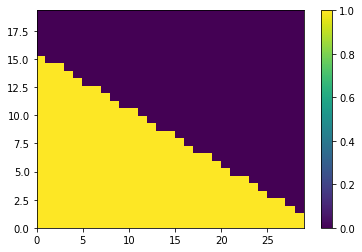

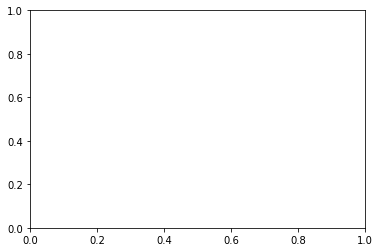

In [9]:
# Here we define the initial condition, and the diffusion matrix for the 2D problem


def make_D_matrix(the_problem, K, decreasing_factor):
    Diff_low = K * decreasing_factor
    n_x, n_y = the_problem.nx, the_problem.ny
    width_x, width_y = the_problem.wx, the_problem.wy
    D_matrix = K * np.ones((n_y, n_x))



    
    #
    # overwrite the center of the image with a low diffusivity
    #
    #for i in range(n_y):
     #   for j in range(n_x):
      #      if (
       #         abs(x[j] - width_x / 2) <= 0.2 * width_x
        #        and abs(y[i] - width_y / 2) <= 0.2 * width_y
         #   ):
          #      D_matrix[i, j] = Diff_low
           #     # here we define a square of low diffusivity in the middle
    return D_matrix

import pdb
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
sat_matrix = np.zeros((len_dam,len_dam))
head = np.zeros((len_dam,len_dam))
c=ylen/len_dam
length_y_p=len(y_p)
#print (length_y_p)
y = np.arange(0,ylen,c)
length_of_y=len(y)
#print(y)
width_x = 10  # dm
width_y = 10  # dm
n_x = length_y_p
n_y = n_x
K = 0.001
the_prob = Problem_Def(n_x, n_y, K, width_x, width_y)
prob = Problem_Def(n_x, n_y, K, width_x, width_y)
Qsource = np.zeros((n_y, n_x))
D_matrix = make_D_matrix(prob, K, decreasing_factor)
#print(D_matrix) 
for j in range(length_y_p):
    for i in range(length_of_y):
        if y_p[j]>=y[i]:
            sat_matrix[i,j] = 1
        else:
            #print(f"debug {i,j}" )
            #if i==2 and j==22:
                #pdb.set_trace()
            sat_matrix[i,j]=0
            #head_2D[i,j]=0
A, b = build_2D_matrix(bc_dict,prob, D_matrix, Qsource,K,y_p, sat_matrix)
head_array = np.linalg.solve(A, b)

n = n_x * n_y
head_2D = vec2mat(head_array, n_y, n_x)
prob = Problem_Def(n_x, n_y, K, width_x, width_y)
for j in range(length_y_p):
    for i in range(length_of_y):
        if y_p[j]>=y[i]:
            sat_matrix[i,j] = 1
        else:
            #print(f"debug {i,j}" )
            #if i==2 and j==22:
                #pdb.set_trace()
            sat_matrix[i,j]=0
            head_2D[i,j]=0

#plt.contourf(sat_matrix)
#plt.colorbar()
y1, x1 = np.mgrid[slice(0, ylen, c),
                slice(0, len_dam, 1)]
plt.pcolormesh(x1,y1,sat_matrix)
plt.colorbar()

#width_x = 10  # dm
#width_y = 10  # dm
#n_x = length_y_p
#n_y = n_x
#K = 0.001

#the_prob = Problem_Def(n_x, n_y, K, width_x, width_y)
#D_matrix = make_D_matrix(the_prob, K, decreasing_factor)
fig, ax = plt.subplots()
# This generates a colormap of diffusion.
cm = cmap.get_cmap("magma")
#plt.contourf(x1, y1, D_matrix, cmap=cm)
#plt.colorbar()

# "magma" refers to a colormap example. You can chose other ones
# https://matplotlib.org/examples/color/colormaps_reference.html

In [10]:
print(head_2D[0,:])

[8.87973406 8.87973406 8.85610685 8.80890297 8.73822294 8.6442163
 8.52708009 8.38705712 8.22443391 8.03953849 7.83273829 7.60443811
 7.35507816 7.08513239 6.79510717 6.48554124 6.15700744 5.81011432
 5.44550166 5.06382851 4.66577568 4.25210792 3.82377334 3.38185439
 2.92710423 2.45981856 1.98046491 1.4934883  1.         1.        ]


This is the 2-D steady state solution using the regular (non-sparse, slow) solver np.linalg.solve

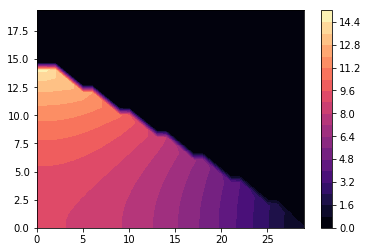

In [11]:
# Here we give you the asymptotic solution to the problem
# we are using everything we have done before

### Asymptotic behavior

#Qsource = np.zeros((n_y, n_x))
#A, b = build_2D_matrix(bc_dict, the_prob, D_matrix, Qsource,K,y_p)
#head_array = np.linalg.solve(A, b)
#n = n_x * n_y
#print(head_array)
# array v contains the solution
# we convert it in a matrix:

#c = vec2mat(head_array, n_y, n_x)

# and we plot the matrix
plt.contourf(x1, y1, head_2D, 20, cmap=cm)
plt.colorbar()

In [12]:
print(y1)

[[ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.        ]
 [ 0.66666667  0.66666667  0.66666667  0.66666667  0.66666667  0.66666667
   0.66666667  0.66666667  0.66666667  0.66666667  0.66666667  0.66666667
   0.66666667  0.66666667  0.66666667  0.66666667  0.66666667  0.66666667
   0.66666667  0.66666667  0.66666667  0.66666667  0.66666667  0.66666667
   0.66666667  0.66666667  0.66666667  0.66666667  0.66666667  0.66666667]
 [ 1.33333333  1.33333333  1.33333333  1.33333333  1.33333333  1.33333333
   1.33333333  1.33333333  1.33333333  1.33333333  1.33333333  1.33333333
   1.33333333  1.33333333  1.33333333  1.33333333  1.33333333  1.33333333
   1.33333333  1.33333333  1.33333333  1.33333333  1.33333333  1.333

This solves the problem using the fast sparse solver spsolve (use this one!)

In [13]:
# Here we give you the asymptotic solution to the problem
# we are using everything we have done before

### Asymptotic behavior

#poro = 0.4
#prob = Problem_Def(n_x, n_y, poro, width_x, width_y)
#Qsource = np.zeros((n_y, n_x))
#A, b = build_2D_matrix(bc_dict, prob, D_matrix, Qsource)
#A = csr_matrix(A, copy=True)

#v = spsolve(A, b)
#n = n_x * n_y
# # array v contains the solution
# # we convert it in a matrix:

#c = vec2mat(v, n_y, n_x)

# # and we plot the matrix
#plt.contourf(x, y, c, 20, cmap=cm)
#plt.colorbar()

In [14]:
psi = np.zeros((n_y, n_x))

vx = np.zeros((n_y,n_x))
vy = np.zeros((n_y,n_x))

dx = 1 #problem.wx / (problem.nx - 1)
dy = 1 #problem.wy / (problem.ny - 1)
n = n_x * n_y

for ind in range(n):
    
    i, j = index_to_row_col(ind, n_y, n_x)
    if(sat_matrix[i,j] == 1):
        if i == 0:  # SOUTH BOUNDARY
            if(sat_matrix[i+1,j] == 1):
                vy[i,j] = (head_2D[i+1,j]-head_2D[i,j])/dy
            
            if j == 0:
                vx[i,j] = (head_2D[i,j+1]-head_2D[i,j])/dx
            elif j == n_x - 1:
                vx[i,j] = (head_2D[i,j]-head_2D[i,j-1])/dx
            else:
                vx[i,j] = (head_2D[i,j+1]-head_2D[i,j-1])/2/dx  
        elif j == 0:   # WEST BOUNDARY
            if(sat_matrix[i,j+1] !=0 and sat_matrix[i+1,j != 0]):
                vx[i,j] = (head_2D[i,j+1]-head_2D[i,j])/dx
                if i == n_y-1:
                    vy[i,j] = (head_2D[i,j]-head_2D[i-1,j])/dy
                else:
                    vy[i,j]=(head_2D[i+1,j]-head_2D[i-1,j])/2/dy  
                    
        elif i == n_y - 1: # NORTH BOUNDARY: should not happen
            vy[i,j] = (head_2D[i,j]-head_2D[i-1,j])/dy
            if j == n_x - 1:
                vx[i,j] = (head_2D[i,j]-head_2D[i,j-1])/dx
            else:
                vx[i,j] = (head_2D[i,j+1]-head_2D[i,j-1])/2/dx
        elif j == n_x - 1:  # EAST BOUNDARY
            if(sat_matrix[i,j-1] !=0 and sat_matrix[i+1,j != 0]):
                vx[i,j] = (head_2D[i,j]-head_2D[i,j-1])/dx
                if i == n_y - 1:
                    vy[i,j] = (head_2D[i,j]-head_2D[i-1,j])/dy
                else:
                    vy[i,j]=(head_2D[i+1,j]-head_2D[i-1,j])/2/dy

        else:
            if(sat_matrix[i,j+1] == 1 and sat_matrix[i+1,j] ==1):
                vx[i,j] = (head_2D[i,j+1]-head_2D[i,j-1])/2/dx
                vy[i,j] = (head_2D[i+1,j]-head_2D[i-1,j])/2/dy
        
        
        
           

/Users/phil/mini37/envs/e213/lib/python3.6/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


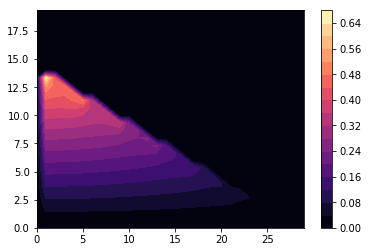

In [15]:
plt.contourf(x1, y1, vy, 20, cmap=cm);
plt.colorbar()  ;

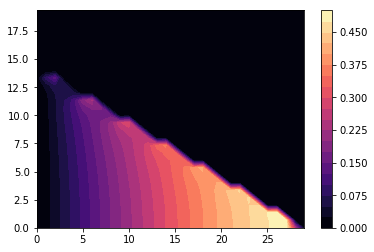

In [16]:
plt.contourf(x1, y1, -vx, 20, cmap=cm);
plt.colorbar()  ;

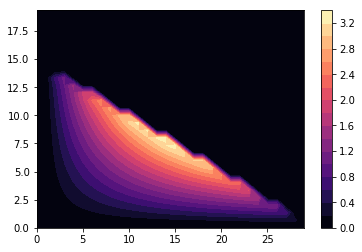

In [17]:
psi = np.zeros((n_y,n_x))
psi[0,0] = 0
for i in range(n_y):
    for j in range (n_x):
        if (j == 0 and i!=0):
            psi[i,j] = psi[i-1,j]-vx[i-1,j]
        elif(i > 0 and j > 0 and sat_matrix[i,j] > 0):
            psi[i,j] = psi[i,j-1] + vy[i,j-1]
            

plt.contourf(x1, y1, psi, 20, cmap=cm)
plt.colorbar()     

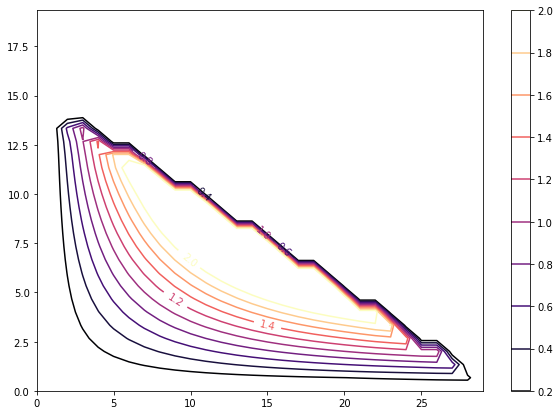

In [19]:
fig, ax = plt.subplots(1,1,figsize=(10,7))
cs=ax.contour(x1, y1, psi, levels=[0.2,0.4,0.6,0.8,1.0,1.2,1.4,1.6,1.8,2.0], cmap=cm)
cb=fig.colorbar(cs)
cb.ax.clabel(cs,[0.4,0.6,0.8,1.0,1.2,1.4, 2.0],fmt="%3.1f");